In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

In [2]:
def get_dataset(d, n_train, n_test):
  x_train = np.random.randn(n_train, d)
  x_test = np.random.randn(n_test, d)
  mean_train = np.empty(d)
  norm_tab = np.empty(n_train)

  norm_train = (np.sum(x_train * x_train, axis = 1) ** 0.5).reshape(n_train, 1)
  x_train = (x_train / norm_train) * (d ** 0.5)
      
  norm_test = (np.sum(x_test * x_test, axis = 1) **0.5).reshape(n_test, 1)
  x_test = (x_test / norm_test) * (d**0.5)

  #On vérifie que notre data set soit uniforme (sur chaque dimension, le dataset a à peu près une moyenne de 0)
  #On se rapproche de plus en plus de 0 lorsqu'on augmente n_train, les données étant mieux réparties
  mean_train = np.sum(x_train, axis = 0) / n_train
      
  #On vérifie que chaque élément de notre dataset ait une norme de sqrt(d)
  norm_tab = np.sum(x_train * x_train, axis = 1) ** 0.5
      
  tau = 0.
  noise_level = tau * tau
  #On veut E(noise) == 0 et E(noise^2) == tau^2
  noise_train = np.random.randn(n_train, 1) * noise_level
  noise_test = np.random.randn(n_test, 1) * noise_level

  F1 = 1

  sample_params = np.random.randn(d, 1)
      
  norm = np.sum(sample_params * sample_params) #should be equal to F1^2
  sample_params = sample_params * (F1 / (norm**0.5))

  y_train = np.dot(x_train, sample_params) + noise_train
  y_test = np.dot(x_test, sample_params) + noise_test

  return x_train, y_train, x_test, y_test

In [3]:
#Quelques fonctions d'activation :

class Sigmoid :
    @staticmethod
    def function(x):
        return 1/(1+np.exp(-x))
    
    @staticmethod
    def gradient(x):
        return Sigmoid.function(x) * Sigmoid.function(-x)
    
class Tanh :
    @staticmethod
    def function(x):
        return np.tanh(x)
        
    @staticmethod
    def gradient(x):
        t = Tanh.function(x)
        return 1-t**2
    
class Relu :
    @staticmethod
    def function(x):
        return np.maximum(x, 0)
    
    @staticmethod
    def gradient(x):
        return x >= 0

class Linear :
    @staticmethod
    def function(x):
        return x
    
    @staticmethod
    def gradient(x):
        return np.ones((x.shape[0], x.shape[1]))

In [4]:
#Quelques Loss Functions :
class MSE:
    @staticmethod
    def loss(y_real, y_hat):
        return np.mean(np.sum((y_hat.T - y_real.T)**2, axis = 0))    
    
    @staticmethod
    def gradient(y_real, y_hat):
        return (2/y_real.shape[0]) * (y_hat - y_real)
    
class reg_MSE:
    def __init__(self, weights, lam):
        self.weights = weights
        self.lam = lam
        
    def loss(self, y_real, y_hat):
        loss = np.mean(np.sum((y_hat.T - y_real.T)**2, axis = 0))
        reg = (np.sum(np.square(self.weights[1])) + np.sum(np.square(self.weights[2])))*(self.lam * self.weights[1].shape[1]/self.weights[1].shape[0])
        return loss + reg
        
    def gradient(self, y_real, y_hat):
        loss_grad = (2/y_real.shape[0]) * (y_hat - y_real)
        reg_grad = (self.lam * self.weights[1].shape[1]/self.weights[1].shape[0]) * (np.sum(self.weights[1]) + np.sum(self.weights[2]))
        return loss_grad + reg_grad

In [5]:
#L'architecture

class Network:
    def __init__(self, dimension_hidden, activation1, activation2):
        """
        dimension_hidden est le nombre de paramètres dans le hidden layer (N dans le papier de Mei et Montanari)
        activation1 est la fonction d'activation du hidden layer
        activation2 est la fonction d'activation de l'output layer
        """
        
        self.nb_layers = 3 #input, hidden, output
        self.dimensions = (d, dimension_hidden, 1)
                
        self.learning_rate = {}
        self.learning_rate[1] = None;  #learning rate du hidden layer
        self.learning_rate[2] = None;  #learning rate du output layer
        
        self.weights = {}
        self.bias = {}
                
        #on initialise les weights et les bias aléatoirement
        for i in range(1, self.nb_layers):
            self.weights[i] = np.random.randn(self.dimensions[i - 1], self.dimensions[i]) / np.sqrt(self.dimensions[i - 1])
            self.bias[i] = np.zeros(self.dimensions[i])
         
        self.activations = {}
        self.activations[2] = activation1
        self.activations[3] = activation2
        
    def forward_pass(self, x):
        """
        x est un vecteur de notre data
        
        return : z contient les paramètres avant que l'on applique l'activation function
        return : a contient les paramètres après que l'on applique l'activation function
        """
        z = {}
        a = {1:x} #l'input layer n'a pas d'activation function, a[1] est donc égal à x
        for i in range(1, self.nb_layers):
            z[i + 1] = np.dot(a[i], self.weights[i]) + self.bias[i] #Z = XW + b
            a[i + 1] = self.activations[i + 1].function(z[i + 1])
            
        return z, a
    
    def predict(self, x):
        _, a = self.forward_pass(x)
        return a[self.nb_layers]
    
    def back_propagation(self, z, a, y_real):
        y_hat = a[self.nb_layers]
        #On calcule delta et la dérivée partielle à l'output layer
        delta = self.loss_function.gradient(y_real, y_hat) * self.activations[self.nb_layers].gradient(y_hat)
        partial_deriv = np.dot(a[self.nb_layers - 1].T, delta)
     
        update_parameters = {
            self.nb_layers - 1: (partial_deriv, delta)
        }
        
        
        #On calcule delta et la dérivée partielle à l'hidden layer
        delta = np.dot(delta, self.weights[2].T) * self.activations[2].gradient(z[2])
        partial_deriv = np.dot(a[1].T, delta) 
        update_parameters[1] = (partial_deriv, delta)
            
        for k, v in update_parameters.items():
            self.update_weights_and_bias(k, v[0], v[1])
            
    def update_weights_and_bias(self, index, partial_deriv, delta):
        self.weights[index] -= self.learning_rate[index] * partial_deriv
        self.bias[index] -= self.learning_rate[index] * np.mean(delta, 0)

    def fit(self, x, y_real, x_test, y_test, loss, nb_iterations = 100, batch_size = 100, learning_rate1 = 0, learning_rate2 = 0.3):
        #On vérifie qu'on a autant de x que de y
        if not (x.shape[0] == y_real.shape[0]):
            raise Exception
            
        loss_tab = []
        
        self.loss_function = loss
        self.learning_rate[1] = learning_rate1
        self.learning_rate[2] = learning_rate2
        
        #We use batch gradient descent
        for i in range(nb_iterations):
            for j in range(x.shape[0] // batch_size):
                start = j * batch_size
                end = (j + 1) * batch_size
                z, a = self.forward_pass(x[start:end])
                self.back_propagation(z, a, y_real[start:end])
            _, a_train = self.forward_pass(x)
            _, a_test = self.forward_pass(x_test)
            loss_tab.append({
                "train_mse":  self.loss_function.loss(y_real, a_train[self.nb_layers]),
                "test_mse":  self.loss_function.loss(y_test, a_test[self.nb_layers]),
            })
            #if(i % 50) == 0:
                #print(f"Loss at Iteration {i} for first batch is {loss_tab[-1]}")
        return loss_tab

d = 100
n_train = 300
n_test = 300

x_train, y_train, x_test, y_test = get_dataset(d, n_train, n_test)
nn = Network(200, Linear, Linear)
config = dict(
        nb_iterations=30000, 
        batch_size=300, 
        learning_rate1=0, 
        learning_rate2=0.001
    )

loss_func = MSE #reg_MSE(nn.weights, 10**(-8))
history = nn.fit(x_train, y_train, x_test, y_test, loss_func, **config)

test_prediction = nn.predict(x_test)
print(test_prediction)

#print(y_test[0])

beta_calc = np.dot(np.dot(np.linalg.inv(np.dot(x_train.T, x_train)), x_train.T), y_train)
real_test_prediction = np.dot(beta_calc.T, x_test.T)
print("#########################")
print(real_test_prediction)
print(MSE.loss(test_prediction, real_test_prediction.T))

df = pd.DataFrame(history)
df.plot(grid=True)
mpl.ylim(-0.1, 3)
mpl.show()

In [6]:
#With the formula

d = 100
n_train = 300
n_test = 100

N_SPACE = np.arange(0.1, 3, 0.1)

l_f = []

for i, N in enumerate(N_SPACE):
    N = int(N*n_train)
    print(f"progress {100*i/len(N_SPACE):.2f}%, N = {N}")
    l0_f = []
    for _ in range(20):
        x_train, y_train, x_test, y_test = get_dataset(d, n_train, n_test)
        beta_calc = np.dot(np.dot(np.linalg.inv(np.dot(x_train.T, x_train)), x_train.T), y_train)
        test_prediction = np.dot(beta_calc.T, x_test.T)
        test_error = MSE.loss(y_test, test_prediction.T)
        l0_f.append(test_error)
        print(test_error)
    l0_f = np.array(l0_f)
    l_f.append({"mean": l0_f.mean(), "std": l0_f.std()})

progress 0.00%, N = 30
1.1768009739189328e-30
5.841268484128711e-31
1.0637373306037356e-30
6.728814039700125e-31
7.501959356574936e-31
7.584812862782476e-31
1.3148862990716087e-30
6.924334447654317e-31
8.87252814219867e-31
8.329955158265897e-31
7.330744184518912e-31
1.5064701062194734e-30
7.83400893828674e-31
1.149945806774397e-30
9.895601387956613e-31
6.240475243001297e-31
9.373886225321554e-31
1.0005283098289466e-30
9.698463198849134e-31
5.898969345262553e-31
progress 3.45%, N = 60
1.1810033530575857e-30
7.159451975265111e-31
1.1340376254337586e-30
7.126191165125543e-31
7.989604818493784e-31
8.898667826368865e-31
1.0193658306149982e-30
7.470142993893659e-31
8.044397525411602e-31
6.956073773137819e-31
7.565457266841384e-31
7.8427719195337015e-31
8.345208523425444e-31
7.904555752149644e-31
8.84756809011941e-31
1.1374080028364362e-30
8.90575043373935e-31
7.336098269764308e-31
6.536163267363069e-31
1.0666517440920797e-30
progress 6.90%, N = 90
1.3103045117339115e-30
1.013571188894823e-30

1.0779121749944257e-30
8.69010405786631e-31
progress 65.52%, N = 600
8.26526317143393e-31
7.104755564844513e-31
6.341548046482739e-31
6.347441392112565e-31
1.2300259738620183e-30
9.934505172833235e-31
1.166607026723291e-30
9.0229817894542e-31
5.27920508915874e-31
1.0617882895000158e-30
7.890303870561179e-31
8.08114426875051e-31
7.384400592769539e-31
1.253892097732865e-30
5.7096311724298435e-31
8.999716555726002e-31
9.410864080253789e-31
1.0601666564868417e-30
5.4528469329446935e-31
7.440637747145647e-31
progress 68.97%, N = 630
8.42178349801428e-31
7.105198528731722e-31
9.716798051919702e-31
1.2092760046411903e-30
1.292784327029821e-30
8.200763777596401e-31
7.601356601004762e-31
7.164998653504946e-31
8.188095973387193e-31
6.307189456274871e-31
9.766236673592122e-31
7.927050613900087e-31
7.868348269195164e-31
1.2601378885425128e-30
7.157449008122948e-31
7.323098242639694e-31
8.180984477067545e-31
9.076368567512615e-31
9.010212873922912e-31
6.750153343483935e-31
progress 72.41%, N = 660


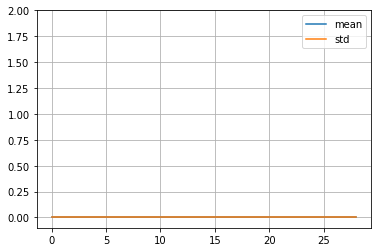

In [7]:
df = pd.DataFrame(l_f)
df.plot(grid=True)
mpl.ylim(-0.1, 2)
mpl.show()

In [8]:
#With the neural network

d = 50
n_train = 150
n_test = 50

N_SPACE = np.arange(0.1, 2, 0.1)

l = []

for i, N in enumerate(N_SPACE):
    N = int(N*n_train)
    print(f"progress {100*i/len(N_SPACE):.2f}%, N = {N}")
    l0 = []
    for _ in range(10):
        x_train, y_train, x_test, y_test = get_dataset(d, n_train, n_test)

        nn = Network(N, Relu, Linear)
        config = dict(
            nb_iterations=500, 
            batch_size=n_train, 
            learning_rate1=0., 
            learning_rate2=0.01
        )
        loss_func = reg_MSE(nn.weights, 10**(-5))
        history = nn.fit(x_train, y_train, x_test, y_test, loss_func, **config)
        test_prediction = nn.predict(x_test)
        final_test_error = nn.loss_function.loss(y_test, test_prediction)
        l0.append(final_test_error)
        print(final_test_error)
    l0 = np.array(l0)
    l.append({"mean": l0.mean(), "std": l0.std()})


progress 0.00%, N = 15
0.8235737674679358
0.6443153104695895
0.620517555617643
0.8922656951605735
0.8806596998612805
0.7437515797538669
0.8460647523737124
0.8504440119263343
0.9768031963052871
0.6848288275427554
progress 5.26%, N = 30
0.6912353672642766
0.35980197603216024
0.6850848166335736
0.5906592790453553
0.648546839269586
1.0260283617190915
0.38927307689846813
0.5581510030054115
0.5423288203569494
1.0047510454550206
progress 10.53%, N = 45
0.7248850988511648
0.6720951844146557
0.3591218234357678
0.6898836244628674
0.5709356307347687
0.5336948530436275
0.5864548135649708
0.5682858797514789
0.8711715685418808
0.5276182310174391
progress 15.79%, N = 60
0.41316708486876524
0.45135678412140295
0.564522633691804
0.6379853308455674
0.5309571475690895
0.3659650278917583
0.635401617528522
0.6891330390403233
0.4110552701011539
0.34926940542075907
progress 21.05%, N = 75
0.5232338496741731
0.5954369927440721
0.43622978449531435
0.5436855901123171
0.4303153287877102
0.30888043876554316
0.408

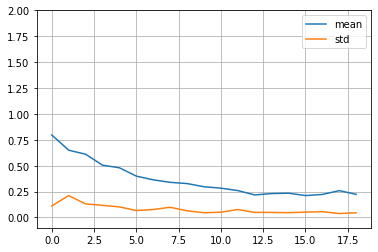

In [9]:
df = pd.DataFrame(l)
df.plot(grid=True)
mpl.ylim(-0.1, 2)
mpl.show()

In [10]:
pd.DataFrame(l)

,mean,std
0,0.796322,0.111465
1,0.649586,0.211169
2,0.610415,0.130772
3,0.504881,0.116846
4,0.479467,0.102043
5,0.399100,0.066698
6,0.363112,0.076258
7,0.339156,0.098406
8,0.327180,0.064252
9,0.296648,0.045288
